In [15]:
pip install --upgrade pyod



[notice] A new release of pip available: 22.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
pip install combo


[notice] A new release of pip available: 22.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
from pandas import json_normalize
import json
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import ruptures as rpt
from collections import Counter

In [18]:
data_path = "datasets"

In [19]:
# No requirement to create multi index for datasets like SWAT

In [20]:
train_data = np.load(data_path + "/SWAT_train.npy")
train_data_label = np.load(data_path + "/SWAT_train_label_mix.npy")
test_data = np.load(data_path+"/SWAT_test.npy")
test_data_label = np.load(data_path + '/SWAT_test_label.npy').astype(int)

In [21]:
# train_data_label = test_data_label[0:len(train_data)]

In [22]:
# train_data_label

In [23]:
# train_data_label = pd.DataFrame(labelled_data.iloc[0:train_size,29].values.astype(int), columns=['isDeviceWorking'])
# test_data_label = pd.DataFrame(labelled_data.iloc[train_size:len(labelled_data),29].values.astype(int), columns=['isDeviceWorking'])
len(train_data)

99000

In [24]:
len(test_data)

89984

In [25]:
len(test_data_label)

89984

In [26]:
# LSTM is a type of RNN - we need sequences that act as an input to the LSTM. Chunks of timestamps are used as sequences

# Create sequences for each device. Take timestamps for each deviceId and form sequences taking 10 time steps at a time.
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [],[]
    for i in range(len(X) - time_steps):
#         Take the value of current time step (x) and do a bit of indexing. 
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])

    return np.array(Xs), np.array(ys)


In [27]:
TIME_STEPS = 200

In [28]:
# Convert train dataset into sequences
# Start with 5 time steps as history.

# TIME_STEPS = 5

X_train, y_train = create_dataset(train_data, train_data_label, TIME_STEPS)
X_test, y_test = create_dataset(test_data,test_data_label,TIME_STEPS)

In [29]:
len(y_test)

89784

In [30]:
# The shape of the created sequence dataset: 
# it's a 3-D tensor which contains the timeseries, time step (history), and number of features
X_train.shape

(98800, 200, 51)

In [31]:
y_train.shape

(98800,)

In [32]:
# The sequences form the input to LSTM Autoencoder
# Idea behind this is to train a model based on our data, measure the error post training. 
# If the error is above a threshold, the model cannot reconstruct the data, indicative of an anomaly (predictive)

In [33]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers
from keras.datasets import imdb
from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

In [34]:
model = Sequential()
# Add an LSTM Layer with 64 units
model.add(LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))

# Add a dropout layer for regularization
model.add(Dropout(rate = 0.2))

# add a repeat layer
# This is important because we need to return the sequence for the next LSTM layer to work with.
model.add(RepeatVector(n=X_train.shape[1]))

# Add another LSTM Layer
model.add(LSTM(
    units=64, 
    return_sequences=True
))
model.add(Dropout(rate = 0.2))

# Output time distributed, fully connected layer 
# return same amount of data that was given as input, 
# that is reconstructed after learning the most important features of our data

model.add(TimeDistributed(Dense(
#     Number of features that we have is the number of dimensions of our predictions column, which is y_train.shape[1]
#     units = X_train.shape[2]   
    units = 1
)))

model.compile(loss='mae', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                29696     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 200, 64)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 200, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 200, 64)           0         
                                                                 
 time_distributed (TimeDistr  (None, 200, 1)           65        
 ibuted)                                                

In [35]:
# Train the model
# Important: In time series data, do not shuffle the data because data is history dependent
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle = False
)

Epoch 1/10
2779/2779 [==============================] - 416s 147ms/step - loss: 0.1789 - val_loss: 0.1751
Epoch 2/10
2779/2779 [==============================] - 365s 131ms/step - loss: 0.1756 - val_loss: 0.1752
Epoch 3/10
2779/2779 [==============================] - 357s 129ms/step - loss: 0.1749 - val_loss: 0.1753
Epoch 4/10
2779/2779 [==============================] - 362s 130ms/step - loss: 0.1749 - val_loss: 0.1752
Epoch 5/10
2779/2779 [==============================] - 400s 144ms/step - loss: 0.1748 - val_loss: 0.1751
Epoch 6/10
2779/2779 [==============================] - 386s 139ms/step - loss: 0.1749 - val_loss: 0.1754
Epoch 7/10
2779/2779 [==============================] - 380s 137ms/step - loss: 0.1747 - val_loss: 0.1753
Epoch 8/10
2779/2779 [==============================] - 366s 132ms/step - loss: 0.1747 - val_loss: 0.1752
Epoch 9/10
2779/2779 [==============================] - 378s 136ms/step - loss: 0.1748 - val_loss: 0.1752
Epoch 10/10
2779/2779 [=======================

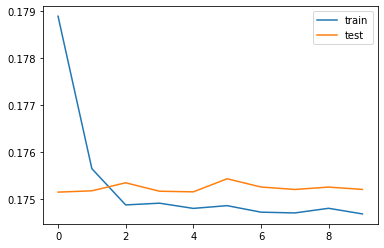

In [36]:
# As you can see, validation loss decreases steadily in above output (indicates some hints of possible learning)

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend();

In [37]:
# Take the predictions for the training data that we have
X_train_pred = model.predict(X_train)

3088/3088 [==============================] - 151s 48ms/step


In [38]:
X_train_pred.shape

(98800, 200, 1)

In [39]:
X_train_pred_reshaped = X_train_pred[:,0,:]

In [40]:
X_train_pred_reshaped.shape

(98800, 1)

In [41]:
y_train.shape

(98800,)

In [43]:
y_train_reshape = y_train.reshape((98800, 1))

In [44]:
y_train_reshape.shape

(98800, 1)

C:\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

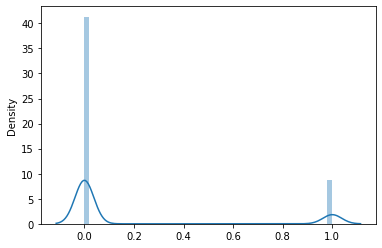

In [45]:
# take mae on training set and calculate error

import seaborn as sns
train_mae_loss = np.mean(np.abs(X_train_pred_reshaped - y_train_reshape), axis =1)
sns.distplot(train_mae_loss, bins=50,kde=True)
# This gives us an idea of what to set as a threshold (which is a hyperparameter)

In [46]:
y_test.shape

(89784,)

In [47]:
# Do the same for test set
X_test_pred = model.predict(X_test)
X_test_pred_reshaped = X_test_pred[:,0,:]
y_test_reshape = y_test.reshape((89784, 1))
test_mae_loss = np.mean(np.abs(X_test_pred_reshaped - y_test_reshape), axis =1)

2806/2806 [==============================] - 143s 51ms/step


In [48]:
len(X_test_pred)

89784

In [49]:
X_test_pred_reshaped.shape

(89784, 1)

C:\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

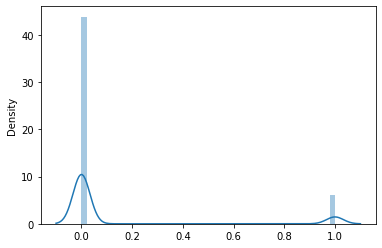

In [50]:
sns.distplot(test_mae_loss, bins=50,kde=True)

In [51]:
test_data_label

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
# Dynamic thresholding: εij = μ(eij ) + zσ(eij )
# Find mean and SD of errors
# Find suitable z to calculate threshold. 

# Find mean with no axis, i.e.:  to compute the mean of the flattened array
mean = np.mean(np.abs(X_train_pred_reshaped - y_train_reshape.astype('float32')))
standard_deviation = np.std(np.abs(X_train_pred_reshaped - y_train_reshape.astype('float32')))

# Dynamic Threshold
# Here, the z value is dynamic
# Values for z depend on context, usually between two and ten to work well based on our experimental results.

# Dynamic Threshold with z = 1-.75
dynamic_threshold = (mean + (0.75*standard_deviation))


In [53]:
dynamic_threshold = 1.0

In [54]:
# Perform thresholding
THRESHOLD = 0.75

test_score_df = pd.DataFrame()
# test_score_df = pd.DataFrame(index=test_data_label[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = dynamic_threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
# test_score_df['isDeviceWorking'] = test_data_label.isDeviceWorking
test_score_df['actual_labels'] = y_test

In [55]:
# test_score_df.loc[test_score_df['anomaly'] == False]
test_score_df

,loss,threshold,anomaly,actual_labels
0,0.000098,1.0,False,0
1,0.000098,1.0,False,0
2,0.000098,1.0,False,0
3,0.000098,1.0,False,0
4,0.000098,1.0,False,0
...,...,...,...,...
89779,0.000098,1.0,False,0
89780,0.000098,1.0,False,0
89781,0.000098,1.0,False,0
89782,0.000098,1.0,False,0


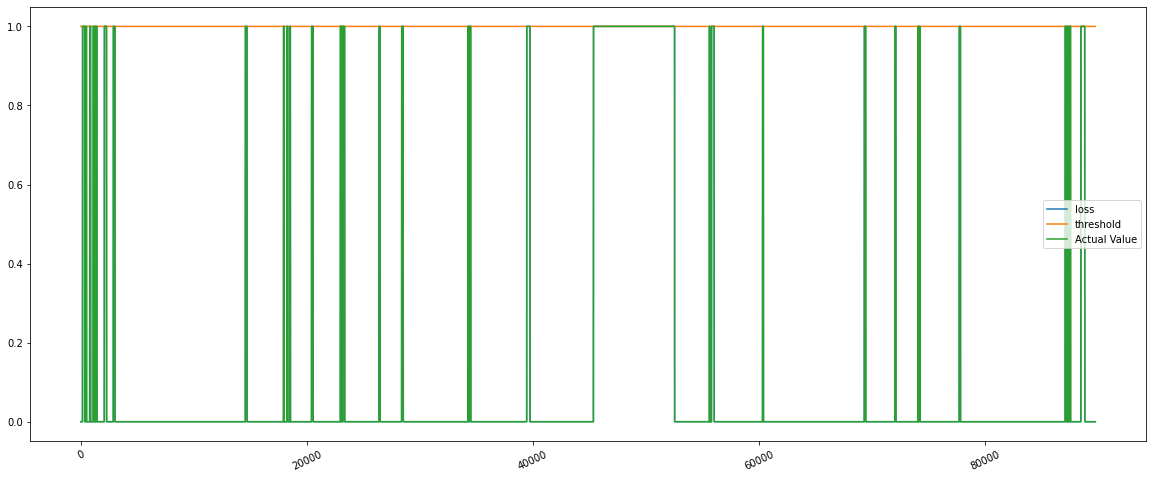

In [56]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)
plt.plot(test_score_df.index, test_score_df.loss, label = 'loss')
plt.plot(test_score_df.index,test_score_df.threshold, label = 'threshold')
plt.plot(test_score_df.index,test_score_df.actual_labels, label = 'Actual Value')
plt.xticks(rotation=25)
plt.legend()

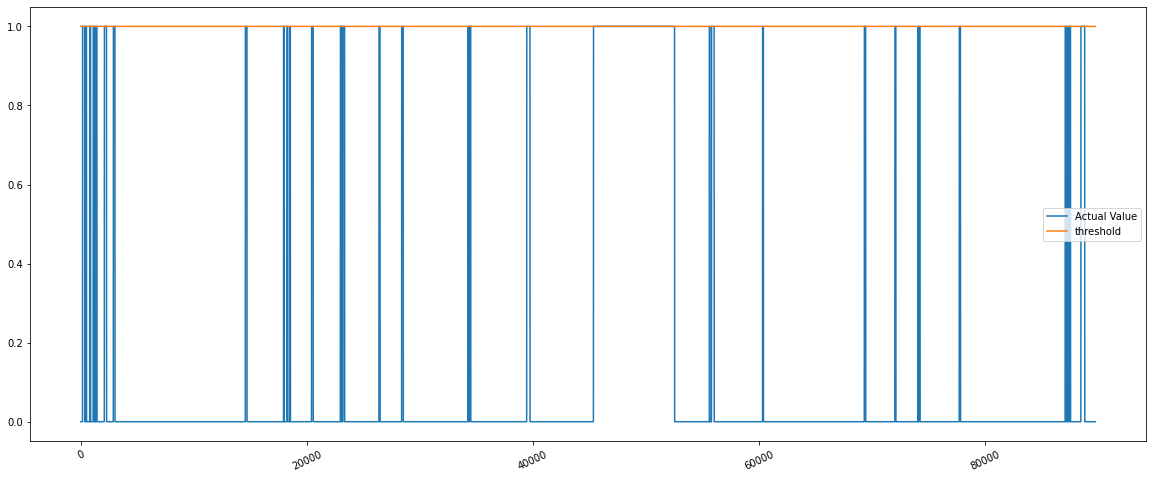

In [57]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)
# plt.plot(test_score_df.index, test_score_df.loss, label = 'loss')
plt.plot(test_score_df.index,test_score_df.actual_labels, label = 'Actual Value')
plt.plot(test_score_df.index,test_score_df.threshold, label = 'threshold')
plt.xticks(rotation=25)
plt.legend()

In [58]:
actual_anomalies = test_score_df[test_score_df.actual_labels == 1.0]
actual_anomalies

,loss,threshold,anomaly,actual_labels
150,1.000098,1.0,True,1
151,1.000098,1.0,True,1
152,1.000098,1.0,True,1
153,1.000098,1.0,True,1
154,1.000098,1.0,True,1
...,...,...,...,...
88834,1.000098,1.0,True,1
88835,1.000098,1.0,True,1
88836,1.000098,1.0,True,1
88837,1.000098,1.0,True,1


In [59]:
detected_anomalies = test_score_df[test_score_df.anomaly == True]
detected_anomalies

,loss,threshold,anomaly,actual_labels
150,1.000098,1.0,True,1
151,1.000098,1.0,True,1
152,1.000098,1.0,True,1
153,1.000098,1.0,True,1
154,1.000098,1.0,True,1
...,...,...,...,...
88834,1.000098,1.0,True,1
88835,1.000098,1.0,True,1
88836,1.000098,1.0,True,1
88837,1.000098,1.0,True,1


In [60]:
 from sklearn.metrics import precision_recall_fscore_support

In [73]:
len(y_test[100:89784])

89684

In [62]:
X_test_pred_reshaped

array([[-9.846846e-05],
       [-9.846853e-05],
       [-9.846854e-05],
       ...,
       [-9.848525e-05],
       [-9.848528e-05],
       [-9.848527e-05]], dtype=float32)

In [74]:
len(test_score_df.loc[0:89684].anomaly)

89685

In [83]:
precision_recall_fscore_support(y_test[100:89784], test_score_df.loc[0:89683].anomaly, average='macro')

(0.8659740747550198, 0.8659740747550198, 0.8659740747550198, None)

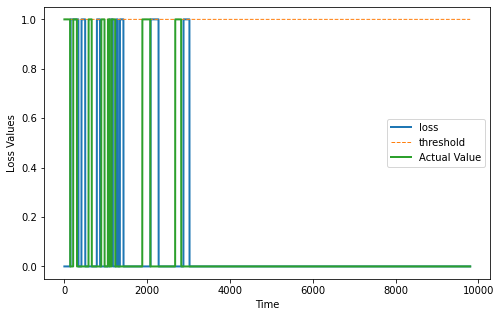

0
150
-150


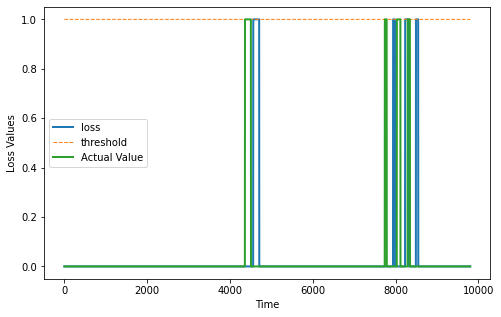

4360
4560
-200


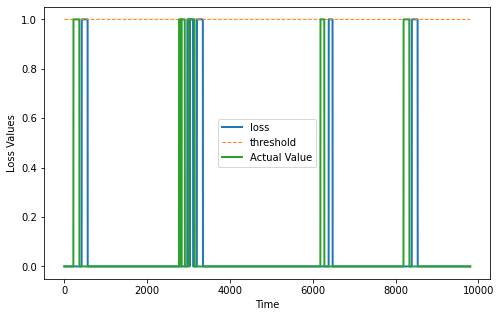

218
418
-200


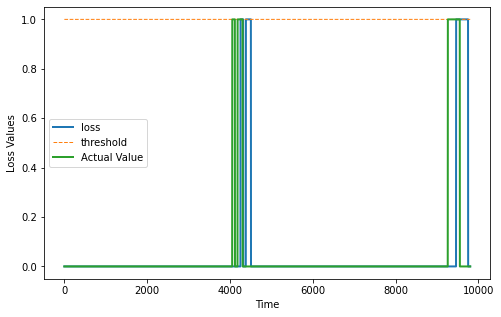

4053
4253
-200


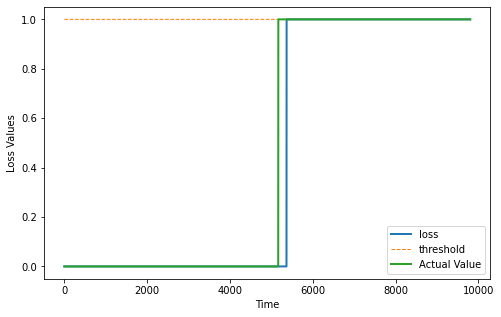

5165
5365
-200


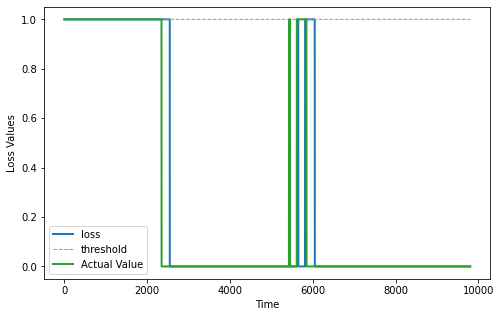

0
0
0


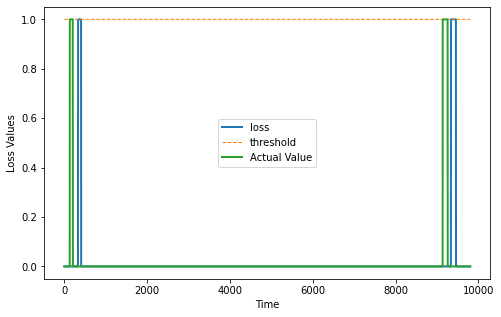

130
330
-200


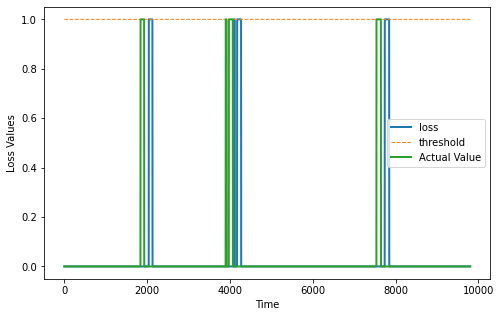

1838
2038
-200


In [82]:
for i in range(0, 79974, 10000):
    fig, ax = plt.subplots(figsize=(8, 5))
    test_actuals = test_score_df.loc[i+200: i+10000].reset_index()
    test_preds = test_score_df.loc[i: i+9800].reset_index()
    loss = test_preds.loss
    threshold = test_preds.threshold
    trueValues = test_actuals.actual_labels
    ax.plot(test_preds.index.values, loss, linewidth=2, label = 'loss')
    ax.plot(test_preds.index.values, threshold, label='threshold',linestyle="--", linewidth=1)
    ax.plot(test_actuals.index.values, trueValues, linewidth=2, label = 'Actual Value')

    # Set x-axis label
    ax.set_xlabel('Time')

    # Set y-axis label
    ax.set_ylabel('Loss Values')

    # Set legend
    ax.legend()

    # Show plot
    plt.show()
    
    indexOfAnomaly = test_actuals.actual_labels.where(test_actuals.actual_labels == 1).first_valid_index()
    print(indexOfAnomaly)
    indexOfAlert = test_preds.loss.where(test_preds.loss >= True).first_valid_index()
    print(indexOfAlert)
    print(indexOfAnomaly - indexOfAlert)